# Working with NetCDF files from the Daymet dataset
This example will demonstrate opening netcdf files in python and extracting precipitation data for a given area.  
More info on the Daymet dataset: https://daymet.ornl.gov/  
This example uses daily gridded data for North America similar to those available here:   
https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/1328/catalog.html

The GISio and GISops modules imported below are available here:
https://github.com/aleaf/GIS_utils  


In [1]:
import sys
import glob
sys.path += glob.glob('D:/github/*')
sys.path.append('E:/ATLData/Documents/GitHub/GSFLOW_climate_utils')
import calendar
import os
import numpy as np
import pandas as pd
import rasterio
from rasterio import features
from rasterio import Affine
import fiona
from shapely.geometry import shape, Point, mapping
import matplotlib.pyplot as plt
import netCDF4
#from PRMSio import netCDF4dataset
from GISio import get_proj4
from GISops import project

%matplotlib inline

### inputs

In [2]:
# list the netcdf files with daily precip
path = 'E:/Daymet/Common_climate/'
prcp_files = glob.glob(path + '*prcp*')

# proj4 string for Daymet data
projection = '+proj=lcc +lat_1=25.0 +lat_2=60.0 +lat_0=42.5 +lon_0=-100.0 +x_0=0.0 +y_0=0.0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs'

# shapefile with polygon of area of interest
model_extent = 'E:/ATLData/USFS/Nicolet/shps/Nicolet_both_ff.shp'

# open shapefile with fiona, get the geoJSON geometry and convert to a shapely polygon
model_extent_poly = shape(next(iter(fiona.open(model_extent)))['geometry'])

# project the shapely polygon from its source project to Daymet coordinate reference system
model_extent_poly = project(model_extent_poly, get_proj4(model_extent), projection)

# make a 1000 km buffer around the area of interest to look at regional patterns
model_extent_buff = model_extent_poly.buffer(100000)

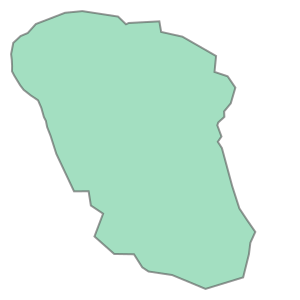

In [3]:
model_extent_poly

### instantiate netcdf Dataset object

In [4]:
f = netCDF4.Dataset(prcp_files[0])

In [5]:
f.variables['x']

<class 'netCDF4._netCDF4.Variable'>
float64 x(x)
    units: m
    long_name: x coordinate of projection
    standard_name: projection_x_coordinate
unlimited dimensions: 
current shape = (5268,)
filling on, default _FillValue of 9.969209968386869e+36 used

### get some information about the NetCDF grid

In [6]:
t0 = pd.Timestamp
nrow = f.variables['y'].shape[0]
ncol = f.variables['x'].shape[0]
xul = f.variables['x'][0]
yul = f.variables['y'][0]
dx = np.diff(f.variables['x'])[0]
dy = np.diff(f.variables['y'])[0]

### make a rasterio `Affine` object that describes the orientation of the grid in space

In [7]:
af = Affine(dx, 0, xul, 0, dy, yul)
af

Affine(1000.0, 0.0, -2014500.0,
       0.0, -1000.0, 1785500.0)

### rasterize the area of interest polygon onto the Daymet grid
the `mapping` function is used to convert from shapely polygon back to geoJSON

In [8]:
raster = features.rasterize([mapping(model_extent_poly)], out_shape=(nrow, ncol),
                            transform=af)

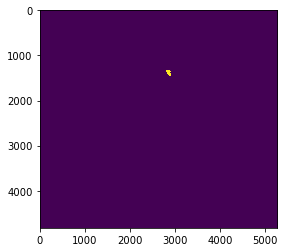

In [9]:
# area of interest within the North America grid
plt.imshow(raster)

### make a mask for the Daymet data; discard parts of the grid away from the area of interest
the "reduce" variable allows for only every nth pixel to be retained, in case a smaller number of pixels are needed (for example, with size limitations for data input files for PRMS)

In [10]:
reduce = 1
# get x and y locations
X, Y = f.variables['x'], f.variables['y']

# build a mask for data; exclude points outside of the area of interest
xreduce = np.array([False] * len(X))
yreduce = np.array([False] * len(Y))
xreduce[::reduce] = True
yreduce[::reduce] = True
xinds = (X[:] > model_extent_buff.bounds[0]) & (X[:] < model_extent_buff.bounds[2]) & xreduce
yinds = (Y[:] > model_extent_buff.bounds[1]) & (Y[:] < model_extent_buff.bounds[3]) & yreduce

# subset raster to model domain
r2 = raster[yinds, :][:, xinds]
xul2 = X[xinds][0]
yul2 = Y[yinds][0]

# make another Affine object that describes the inset grid location
af2 = Affine(dx, 0, xul2, 0, dy, yul2)
nrow2, ncol2 = r2.shape

def window(raster):
    return raster[:, yinds, :][:, :, xinds]

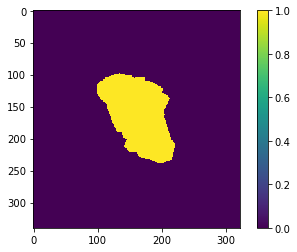

In [11]:
# the reduced grid
plt.imshow(r2)
plt.colorbar()

### select a subset of the precip .nc files

In [12]:
prcp_files[1840:-91]

['E:/Daymet/Common_climate\\2000-00_prcp.nc',
 'E:/Daymet/Common_climate\\2000-01_prcp.nc',
 'E:/Daymet/Common_climate\\2000-02_prcp.nc',
 'E:/Daymet/Common_climate\\2000-03_prcp.nc',
 'E:/Daymet/Common_climate\\2000-04_prcp.nc',
 'E:/Daymet/Common_climate\\2000-05_prcp.nc',
 'E:/Daymet/Common_climate\\2000-06_prcp.nc',
 'E:/Daymet/Common_climate\\2000-07_prcp.nc',
 'E:/Daymet/Common_climate\\2000-08_prcp.nc',
 'E:/Daymet/Common_climate\\2000-09_prcp.nc',
 'E:/Daymet/Common_climate\\2000-10_prcp.nc',
 'E:/Daymet/Common_climate\\2000-11_prcp.nc',
 'E:/Daymet/Common_climate\\2000-12_prcp.nc',
 'E:/Daymet/Common_climate\\2000-13_prcp.nc',
 'E:/Daymet/Common_climate\\2000-14_prcp.nc',
 'E:/Daymet/Common_climate\\2000-15_prcp.nc',
 'E:/Daymet/Common_climate\\2000-16_prcp.nc',
 'E:/Daymet/Common_climate\\2000-17_prcp.nc',
 'E:/Daymet/Common_climate\\2000-18_prcp.nc',
 'E:/Daymet/Common_climate\\2000-19_prcp.nc',
 'E:/Daymet/Common_climate\\2000-20_prcp.nc',
 'E:/Daymet/Common_climate\\2000-2

### open the files, load arrays of data and times into lists

In [13]:
k = 'prcp' # precipitation suffix
arrays = []
times = []
for f in prcp_files[1840:-91]:
    nc = netCDF4.Dataset(f)
    
    # get the time offset; convert to pandas Timestamp
    t0_str = nc.variables['time'].units.strip('days since ')
    t0 = pd.Timestamp(t0_str)
    
    # convert the Daymet times to absolute Timestamps
    t = pd.to_timedelta(nc.variables['time'][:], unit='d') + t0
    
    # append the data array and times
    arrays.append(window(nc.variables['prcp']))
    times += t.tolist()

### aggregate data to single 3D numpy array; times to pandas time series

In [14]:
a = np.vstack(arrays)
times = pd.to_datetime(times)

### create a data `Panel`
allows for easy indexing across x, y, and time  
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Panel.html

In [15]:
pn = pd.Panel(a, items=times)

### compute annual means across dataset

In [16]:
years = pn.groupby(pn.axes[0].year, axis='items').sum()

### plot mean annual precip for whole period

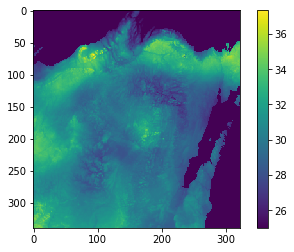

In [17]:
# convert from mm to inches
p_an_in = years.mean(axis=0).values * 12 /(1000 * .3048)

# convert no data values (open water) to zero
p_an_in[p_an_in < 0] = 0.
plt.imshow(p_an_in, vmin=25)
plt.colorbar()

### make a GeoTiff of average precip over the inset grid

In [18]:
meta = {'driver':'GTiff', 
        'height': nrow2,
        'width': ncol2,
        'transform': af2,
        'count': 1,
        'dtype': np.float64,
        'crs': projection,
        'nodata': 0}
with rasterio.open('annual_precip_in.tif', 'w', **meta) as dst:
    dst.write(p_an_in, 1)